In [1]:
import random

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

random.seed(42)

In [2]:
results = pd.read_csv("../reports/model_metrics_2.csv")

In [3]:
results_sorted = results.sort_values(by='latency')
results_sorted

,model,accuracy,train_accuracy,recall,precision,cost,latency,date
16,fastText_finance_fastText,92.74,0.929952,90.89,94.29,0.000000,9.606843e+03,2025-03-09 16:58:44.153712
11,fastText_healthcare_fastText,98.56,0.984714,98.57,98.53,0.000000,1.315049e+04,2025-03-09 16:47:45.569511
6,fastText_law_fastText,98.38,0.984619,97.88,98.88,0.000000,1.916364e+04,2025-03-09 16:31:38.102691
9,SVM_law_baai,99.82,0.998000,99.80,99.85,0.000000,3.545980e+05,2025-03-09 16:47:32.346001
14,SVM_healthcare_baai,99.59,0.995762,99.42,99.75,0.000000,3.606674e+05,2025-03-09 16:58:33.005596
20,XGBoost_finance_baai,98.94,0.999952,99.53,98.36,0.000000,4.451443e+05,2025-03-09 17:09:06.562929
15,XGBoost_healthcare_baai,99.69,0.999905,99.53,99.84,0.000000,4.710728e+05,2025-03-09 16:58:40.842610
18,XGBoost_finance_mini,98.88,0.999952,99.42,98.34,0.000000,4.763139e+05,2025-03-09 17:01:37.153628
8,XGBoost_law_mini,99.71,1.000000,99.73,99.69,0.000000,4.764222e+05,2025-03-09 16:33:23.166583
10,XGBoost_law_baai,99.78,1.000000,99.89,99.67,0.000000,4.771734e+05,2025-03-09 16:47:40.538157


In [4]:
results_sorted = results.sort_values(by='precision', ascending=False)
results_sorted

,model,accuracy,train_accuracy,recall,precision,cost,latency,date
9,SVM_law_baai,99.82,0.998000,99.80,99.85,0.000000,3.545980e+05,2025-03-09 16:47:32.346001
15,XGBoost_healthcare_baai,99.69,0.999905,99.53,99.84,0.000000,4.710728e+05,2025-03-09 16:58:40.842610
13,XGBoost_healthcare_mini,99.76,0.999905,99.71,99.80,0.000000,4.992307e+05,2025-03-09 16:49:27.293670
12,SVM_healthcare_mini,99.67,0.997952,99.53,99.80,0.000000,4.933148e+05,2025-03-09 16:49:18.127305
7,SVM_law_mini,99.80,0.999190,99.82,99.78,0.000000,5.379578e+05,2025-03-09 16:33:15.826894
14,SVM_healthcare_baai,99.59,0.995762,99.42,99.75,0.000000,3.606674e+05,2025-03-09 16:58:33.005596
8,XGBoost_law_mini,99.71,1.000000,99.73,99.69,0.000000,4.764222e+05,2025-03-09 16:33:23.166583
10,XGBoost_law_baai,99.78,1.000000,99.89,99.67,0.000000,4.771734e+05,2025-03-09 16:47:40.538157
6,fastText_law_fastText,98.38,0.984619,97.88,98.88,0.000000,1.916364e+04,2025-03-09 16:31:38.102691
11,fastText_healthcare_fastText,98.56,0.984714,98.57,98.53,0.000000,1.315049e+04,2025-03-09 16:47:45.569511


In [5]:
results_sorted = results.sort_values(by='accuracy', ascending=False)
results_sorted

,model,accuracy,train_accuracy,recall,precision,cost,latency,date
9,SVM_law_baai,99.82,0.998000,99.80,99.85,0.000000,3.545980e+05,2025-03-09 16:47:32.346001
7,SVM_law_mini,99.80,0.999190,99.82,99.78,0.000000,5.379578e+05,2025-03-09 16:33:15.826894
10,XGBoost_law_baai,99.78,1.000000,99.89,99.67,0.000000,4.771734e+05,2025-03-09 16:47:40.538157
13,XGBoost_healthcare_mini,99.76,0.999905,99.71,99.80,0.000000,4.992307e+05,2025-03-09 16:49:27.293670
8,XGBoost_law_mini,99.71,1.000000,99.73,99.69,0.000000,4.764222e+05,2025-03-09 16:33:23.166583
15,XGBoost_healthcare_baai,99.69,0.999905,99.53,99.84,0.000000,4.710728e+05,2025-03-09 16:58:40.842610
12,SVM_healthcare_mini,99.67,0.997952,99.53,99.80,0.000000,4.933148e+05,2025-03-09 16:49:18.127305
14,SVM_healthcare_baai,99.59,0.995762,99.42,99.75,0.000000,3.606674e+05,2025-03-09 16:58:33.005596
20,XGBoost_finance_baai,98.94,0.999952,99.53,98.36,0.000000,4.451443e+05,2025-03-09 17:09:06.562929
18,XGBoost_finance_mini,98.88,0.999952,99.42,98.34,0.000000,4.763139e+05,2025-03-09 17:01:37.153628


In [6]:
# First, define a consistent color scheme to use in both visualizations
domain_colors = {'law': 'cornflowerblue', 'healthcare': 'orange', 'finance': 'mediumseagreen'}

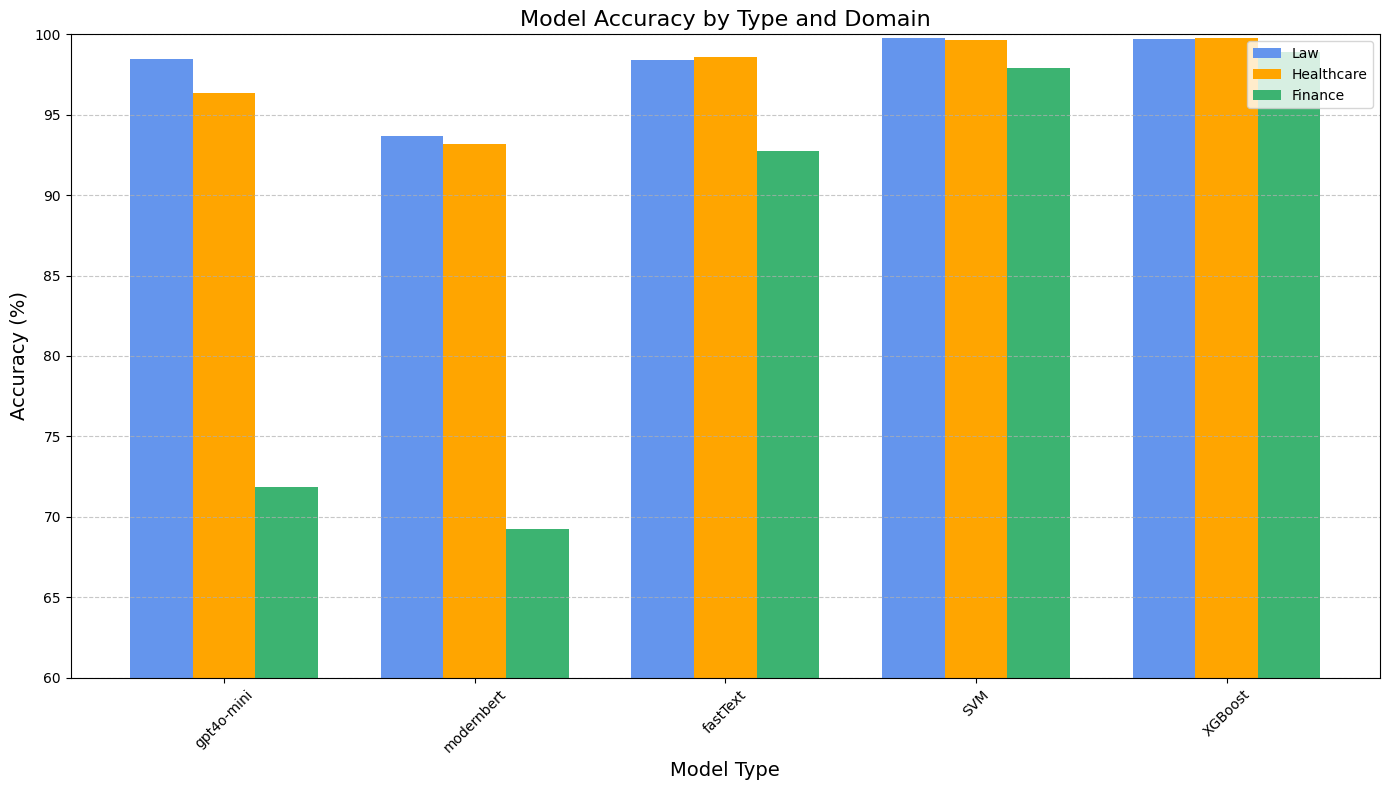

In [7]:
# Extract model type and domain from the model name
results['model_type'] = results['model'].apply(lambda x: x.split('_')[0])
results['domain'] = results['model'].apply(lambda x: x.split('_')[1])

# Set up the figure
fig, ax = plt.subplots(figsize=(14, 8))

# Get unique model types and domains
model_types = results['model_type'].unique()
domains = results['domain'].unique()
width = 0.25  # width of the bars
x = np.arange(len(model_types))

# Plot grouped bar chart
for i, domain in enumerate(domains):
    domain_data = results[results['domain'] == domain]
    accuracies = []
    
    for model_type in model_types:
        model_accuracy = domain_data[domain_data['model_type'] == model_type]['accuracy'].values
        if len(model_accuracy) > 0:
            accuracies.append(model_accuracy[0])
        else:
            accuracies.append(0)
            
    ax.bar(x + (i-1)*width, accuracies, width, label=domain.capitalize(), color=domain_colors.get(domain, 'gray'))

# Customize plot
ax.set_title('Model Accuracy by Type and Domain', fontsize=16)
ax.set_xlabel('Model Type', fontsize=14)
ax.set_ylabel('Accuracy (%)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(model_types, rotation=45)
ax.set_ylim([60, 100])
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

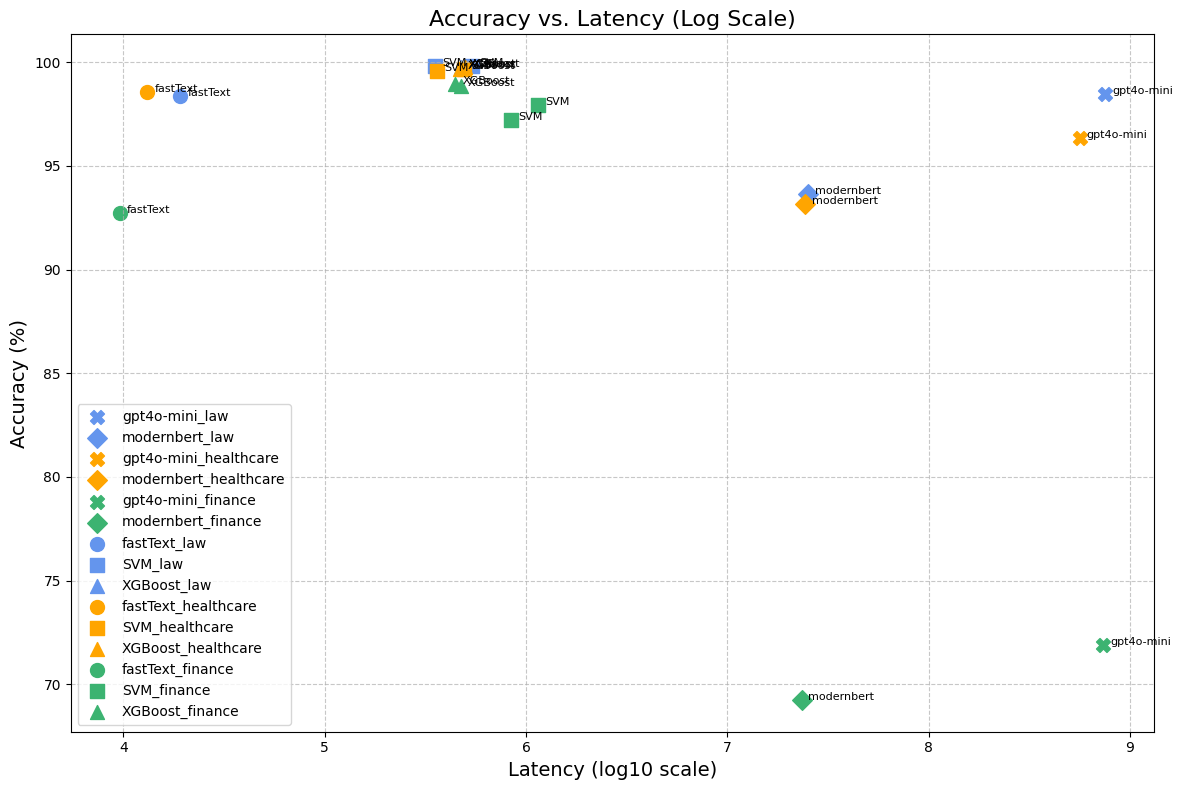

In [8]:
# Create figure for trade-off visualization
fig, ax = plt.subplots(figsize=(12, 8))

# Convert latency to log scale for better visualization
results['log_latency'] = np.log10(results['latency'])

# Define markers and colors for different categories
markers = {'fastText': 'o', 'SVM': 's', 'XGBoost': '^', 'modernbert': 'D', 'gpt4o-mini': 'X'}

# Plot scatter points
for i, row in results.iterrows():
    ax.scatter(row['log_latency'], row['accuracy'], 
               marker=markers.get(row['model_type'], '*'),
               color=domain_colors.get(row['domain'], 'gray'),
               s=100,
               label=f"{row['model_type']}_{row['domain']}")

# Add a legend (only once for each unique combination)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='best')

    
# Customize plot
ax.set_title('Accuracy vs. Latency (Log Scale)', fontsize=16)
ax.set_xlabel('Latency (log10 scale)', fontsize=14)
ax.set_ylabel('Accuracy (%)', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)

# Add model type as annotations
for i, row in results.iterrows():
    ax.annotate(row['model_type'], 
                xy=(row['log_latency'], row['accuracy']),
                xytext=(5, 0), 
                textcoords='offset points',
                fontsize=8)

plt.tight_layout()
plt.show()

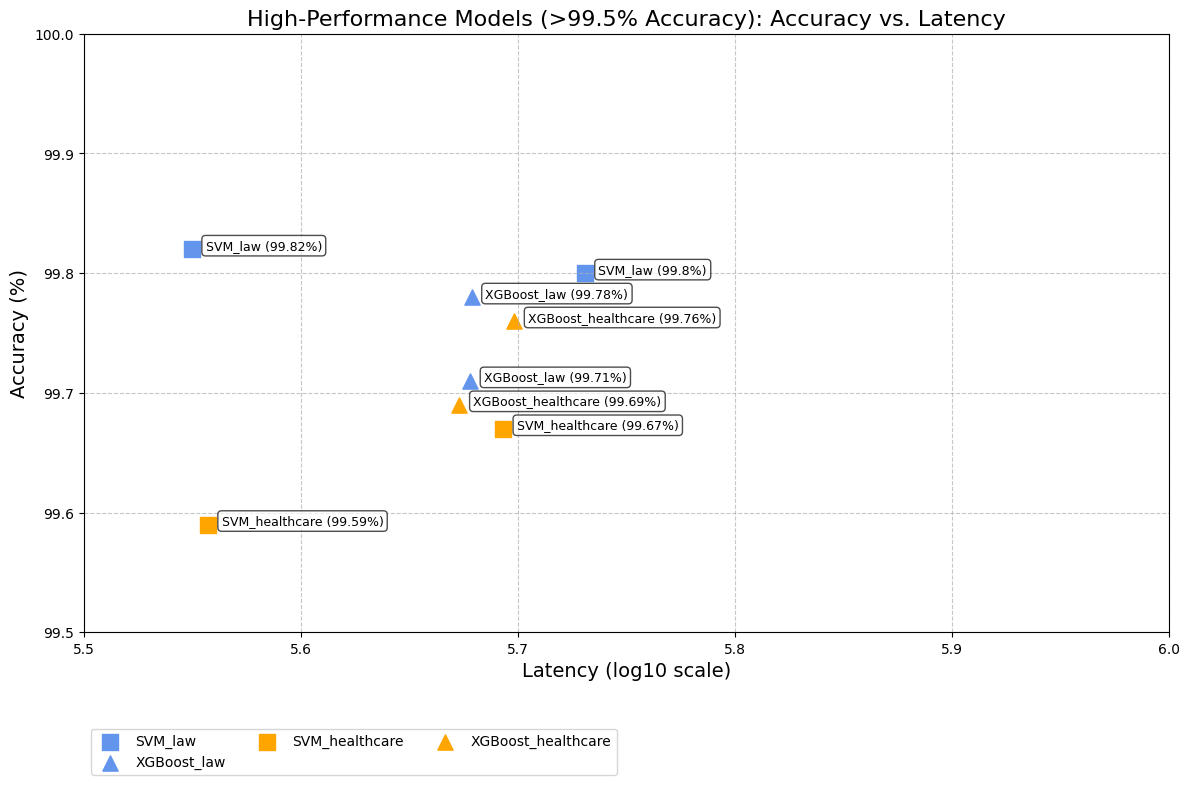

In [9]:
# Create figure for zoomed-in visualization of top-performing models
plt.figure(figsize=(12, 8))

# Filter only high-performing models (accuracy > 99.5%)
high_performance = results[results['accuracy'] > 99.5]

# Create scatter plot with different markers and colors
for i, row in high_performance.iterrows():
    plt.scatter(row['log_latency'], row['accuracy'], 
               marker=markers.get(row['model_type'], '*'),
               color=domain_colors.get(row['domain'], 'gray'),
               s=120,
               label=f"{row['model_type']}_{row['domain']}")

# Add labels to each point
for i, row in high_performance.iterrows():
    plt.annotate(f"{row['model_type']}_{row['domain']} ({row['accuracy']}%)", 
                xy=(row['log_latency'], row['accuracy']),
                xytext=(10, 0), 
                textcoords='offset points',
                fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7))

# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='lower left', bbox_to_anchor=(0, -0.25), ncol=3)

# Set axis limits to zoom in on the high-performance region
plt.xlim(5.5, 6)  # Adjust based on log_latency values
plt.ylim(99.5, 100) # Slightly above 100 to give room for annotations

# Customize plot
plt.title('High-Performance Models (>99.5% Accuracy): Accuracy vs. Latency', fontsize=16)
plt.xlabel('Latency (log10 scale)', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()